### Install

In [1]:
# run this cell to install Julia
# F5 to refresh

%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.6.3" # any version ≥ 0.7.0
JULIA_PACKAGES="IJulia"
JULIA_NUM_THREADS=9
#---------------------------------------------------#

if [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia  

  echo ''
  echo "Successfully installed `julia -v`!"
  echo "Please reload this page (press Ctrl+R, ⌘+R, or the F5 key)"
fi

Unrecognized magic `%%shell`.

Julia does not use the IPython `%magic` syntax.   To interact with the IJulia kernel, use `IJulia.somefunction(...)`, for example.  Julia macros, string macros, and functions can be used to accomplish most of the other functionalities of IPython magics.


In [2]:
versioninfo()

Julia Version 1.6.3
Commit ae8452a9e0 (2021-09-23 17:34 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Xeon(R) CPU @ 2.20GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-11.0.1 (ORCJIT, broadwell)
Environment:
  JULIA_NUM_THREADS = 9


### Juila

In [3]:
using Pkg
Pkg.add("LinearAlgebra")
Pkg.add("Plots")
Pkg.add("Images")

using LinearAlgebra
using Plots
using Images

    Updating registry at `~/.julia/registries/General`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`


### Problem 1

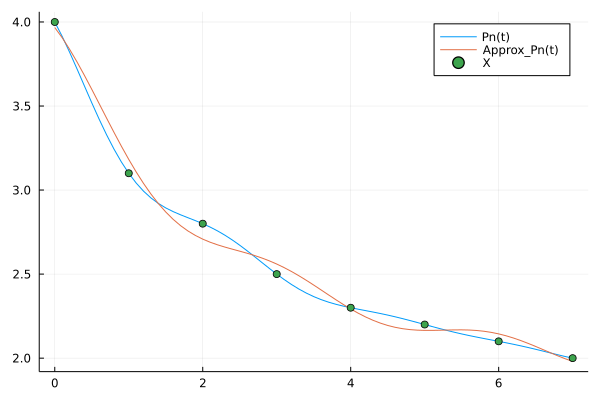

In [4]:
# function cbf
function cbf(n, i, j)
  if(i == 1)
    return 1/sqrt(n)
  else
    return sqrt(2/n) * cos((i-1)*(2j-1)*pi/(2n))
  end
end

# function P_n(t)
function Pn(t, Y)
  n = length(Y)
  val = 0
  for i = 1:n
    val = val + Y[i]*cbf(n, i, t+1)
  end
  return val
end

# Create matrix C
n = 8
C = [cbf(n, i, j) for i=1:n, j=1:n]

# data X
X = [4.0 3.1 2.8 2.5 2.3 2.2 2.1 2.0]'

# Y
Y = C*X

# Y_bar
Y_bar = copy(Y)
k = 6                     # keep the first k elements
Y_bar[k+1:n] = zeros(n-k)

# plots
t = [0:0.1:7;]

p = [Pn(t1, Y) for t1 in t]
plot(t, p, label="Pn(t)")

approx_p = [Pn(t1, Y_bar) for t1 in t]
plot!(t, approx_p, label="Approx_Pn(t)")

scatter!([0:1:7;], X, label="X")           # plot points

### Problem 2

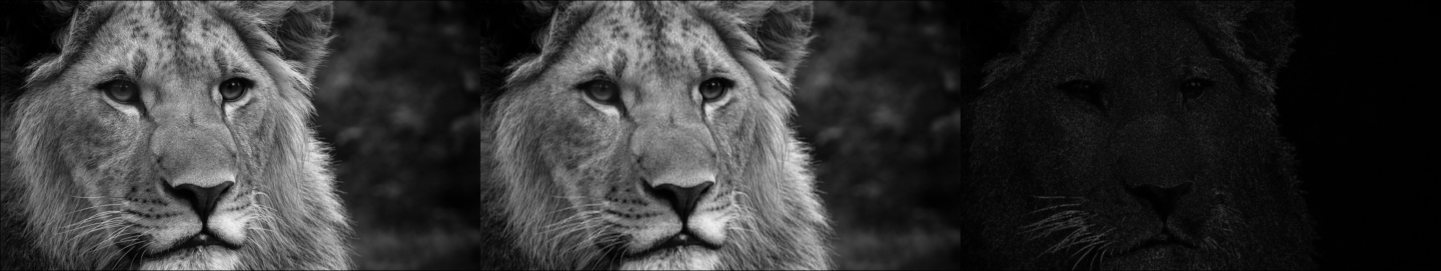

In [5]:
# -----------------------------------------------------------------------
# --------------------------------- (a) ---------------------------------
# -----------------------------------------------------------------------

# function Discrete Cosine Transform Compression, input is matrix A and loss l
function dctcomp(A, l)

  # Level-shifting matrix A to matrix B
  m, n = size(A)
  O = ones(m,n)
  B = 255*A-127*O

  # Construct matrix C
  C = [cbf(8, i, j) for i=1:8, j=1:8]
  
  # Create Mask for transform Y to Y2
  Mask = [i + j < l for i=1:8, j=1:8]

  # Create matrix B_bar
  B_bar = ones(m, n)
  a = Int(floor(m/8))
  b = Int(floor(n/8))
  for i=1:a, j=1:b
    rows = (8i-7):8i
    cols = (8j-7):8j
    X = B[rows, cols]
    Y = C*X*C'
    Y2 = Y.*Mask
    X2 = C'*Y2*C
    B_bar[rows,cols] = X2
  end

  # Level-shifting B_bar to A_bar
  A_bar = (B_bar + 127*O)/255
  return A_bar
end

# load image and store as the matrix A
img = load("/content/lion.jpg")
img1 = Gray.(img)
A = channelview(img1)

# Discrete Cosine Transform compress matrix A with the given l
l = 4
A_comp = dctcomp(A,l)

# plot them
img2 = colorview(Gray, A_comp)
img3 = colorview(Gray, abs.(A - A_comp))
mosaicview(img1, img2, img3, nrow = 1)

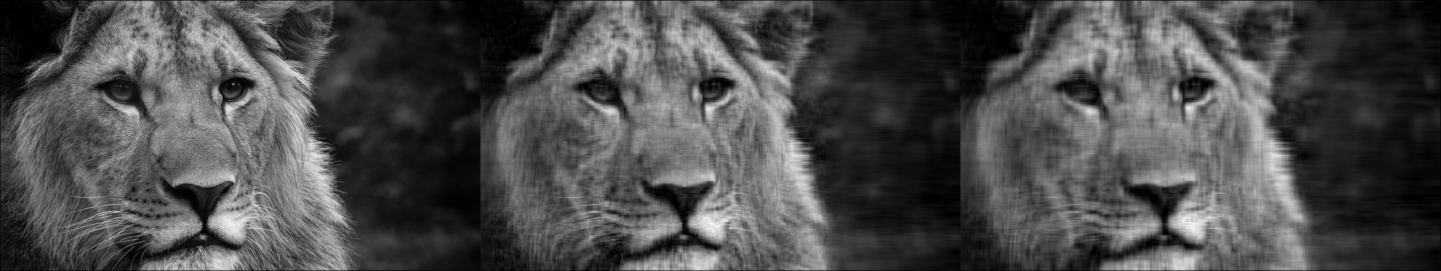

In [6]:
# -----------------------------------------------------------------------
# --------------------------------- (b) ---------------------------------
# -----------------------------------------------------------------------

# Low rank approximation function
function low_rank_approx(A, k)
  # create U_k, S_k, V_k
  U,S,V = svd(A)
  U_k = U[:,1:k]
  S_k = S[1:k]
  V_k = V[:,1:k]

  # construct approximated matrix A_k
  A_k = U_k*diagm(S_k)*V_k'

  # return matrix A_k
  return A_k
end

# load image and store as the matrix A
img = load("/content/lion.jpg")
img1 = Gray.(img)
A = channelview(img1)

# Construct A_30, A_20
A_30 = low_rank_approx(A, 30)
A_20 = low_rank_approx(A, 20)

# plot them
img4 = colorview(Gray, A_30)
img5 = colorview(Gray, A_20)
mosaicview(img1, img4, img5, nrow = 1)

### Problem 3

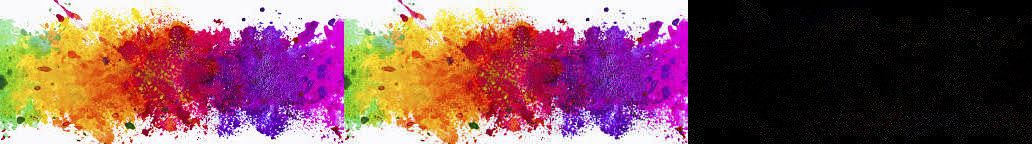

In [7]:
# function Discrete Cosine Transform Compression, input is matrix A and quantization Q
function dctcomp_quant(A, Q)
  # Level-shifting matrix A to matrix B
  m, n = size(A)
  O = ones(m,n)
  B = 255*A-127*O

  # Construct matrix C
  C = [cbf(8, i, j) for i=1:8, j=1:8]

  # Create matrix B_bar
  B_bar = ones(m, n)
  a = Int(floor(m/8))
  b = Int(floor(n/8))
  for i=1:a, j=1:b
    rows = (8i-7):8i
    cols = (8j-7):8j
    X = B[rows, cols]
    Y = C*X*C'
    Y2 = round.(Y./Q).*Q
    X2 = C'*Y2*C
    B_bar[rows,cols] = X2
  end

  # Level-shifting B_bar to A_bar
  A_bar = (B_bar + 127*O)/255
  return A_bar
end

# load image A and decompose A to R, G, B
img6 = load("/content/colors.jpg")
A = channelview(img6)
R = A[1,:,:]
G = A[2,:,:]
B = A[3,:,:]

# Construct Y, U, V from R, G, B
Y = 0.299*R + 0.587*G + 0.114*B
U = B - Y
V = R - Y

# Quantizations
# luminance quantization
lum_Q = [
16 11 10 16 24  40  51  61 ;
12 12 14 19 26  58  60  55 ;
14 13 16 24 40  57  69  56 ;
14 17 22 29 51  87  80  62 ;
18 22 37 56 68  109 103 77 ;
24 35 55 64 81  104 113 92 ;
49 64 78 87 103 121 120 101;
72 92 95 98 112 100 103 99 ;
]

# chrominance quantization
chro_Q = [
17 18 24 47 99 99 99 99 ;
18 21 26 66 99 99 99 99 ;
24 26 56 99 99 99 99 99 ;
47 66 99 99 99 99 99 99 ;
99 99 99 99 99 99 99 99 ;
99 99 99 99 99 99 99 99 ;
99 99 99 99 99 99 99 99 ;
99 99 99 99 99 99 99 99 ;
]

# Construct Y_bar, U_bar, V_bar
Y_bar = dctcomp_quant(Y, lum_Q)
U_bar = dctcomp_quant(U, chro_Q)
V_bar = dctcomp_quant(V, chro_Q)

# Compute R_bar, G_bar, B_bar
B_bar = U_bar + Y_bar
R_bar = V_bar + Y_bar
G_bar = (Y_bar - 0.299*R_bar - 0.114*B_bar)/0.587

# Reconstruct A_comp
A_comp = zeros(3, 144, 344)
A_comp[1,:,:] = R_bar
A_comp[2,:,:] = G_bar
A_comp[3,:,:] = B_bar

# plots
img7 = colorview(RGB, A_comp)
img8 = colorview(RGB, A - A_comp)
mosaicview(img6, img7, img8, nrow = 1)

### Problem 4

In [8]:
# Symbols and Frequencies
S = ["A", "E", "H", "L", "S", " "]
F = [ 1    4    2    4    6    2 ]

S1 = ["AH", "E", "L", "S", "_"]
F1 = [ 3     4    4    6    2 ]

S2 = ["AH_", "E", "L", "S"]
F2 = [ 5      4    4    6 ]

S3 = ["AH_", "EL", "S"]
F3 = [ 5      8     6 ]

S4 = ["AH_S", "EL"]
F4 = [  11     8  ]

S5 = ["AH_SEL"]
F5 = [   19   ]

1-element Vector{Int64}:
 19

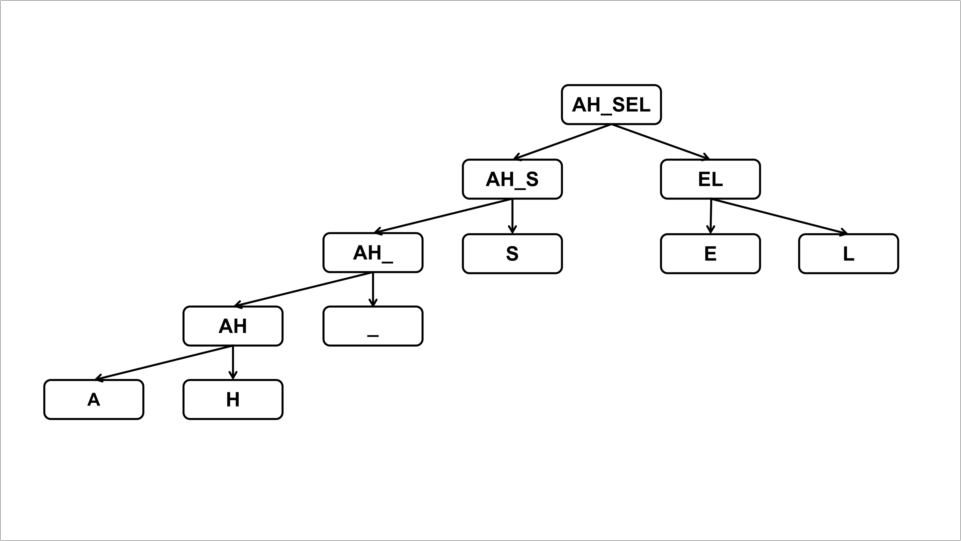

In [9]:
# -----------------------------------------------------------------------
# --------------------------------- (b) ---------------------------------
# -----------------------------------------------------------------------

img9 = load("/content/tree.png")

In [10]:
# -----------------------------------------------------------------------
# --------------------------------- (a) ---------------------------------
# -----------------------------------------------------------------------

# Huffman coding
A = "0000"
E = "10"
H = "0001"
L = "11"
S = "01"
sp = "001"

"001"

In [11]:
# -----------------------------------------------------------------------
# --------------------------------- (c) ---------------------------------
# -----------------------------------------------------------------------

H_code = S*H*E*sp*S*E*L*L*S*sp*S*E*A*S*H*E*L*L*S

"0100011000101101111010010110000001000110111101"

In [12]:
# -----------------------------------------------------------------------
# --------------------------------- (d) ---------------------------------
# -----------------------------------------------------------------------

# Fixed length code
A = "000"
E = "001"
H = "010"
L = "011"
S = "100"
sp = "101"

F_l_code = S*H*E*sp*S*E*L*L*S*sp*S*E*A*S*H*E*L*L*S

# save storage
saved = 100 - length(H_code)/length(F_l_code)*100

println("Huffman code:       ", H_code)
println("Fixed length code:  ", F_l_code)
print("We can save ", saved, "% storage")

Huffman code:       0100011000101101111010010110000001000110111101
Fixed length code:  100010001101100001011011100101100001000100010001011011100
We can save 19.298245614035096% storage